In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import xgboost as xgb

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Activation, Dropout, Input
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, Callback
from keras_radam import RAdam

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sentiment

stop_words = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

Using TensorFlow backend.


In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample = pd.read_csv('input/sample_submission.csv')

In [3]:
train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


## EDA

In [4]:
print("Train: ",train.shape)
print("Test: ",test.shape)
print("Sample Sub: ",sample.shape)

Train:  (6079, 41)
Test:  (476, 11)
Sample Sub:  (476, 31)


In [5]:
sample.columns

Index(['qa_id', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

In [6]:
train.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [7]:
train.isnull().sum(axis=0) 

qa_id                                    0
question_title                           0
question_body                            0
question_user_name                       0
question_user_page                       0
answer                                   0
answer_user_name                         0
answer_user_page                         0
url                                      0
category                                 0
host                                     0
question_asker_intent_understanding      0
question_body_critical                   0
question_conversational                  0
question_expect_short_answer             0
question_fact_seeking                    0
question_has_commonly_accepted_answer    0
question_interestingness_others          0
question_interestingness_self            0
question_multi_intent                    0
question_not_really_a_question           0
question_opinion_seeking                 0
question_type_choice                     0
question_ty

In [8]:
train_columns=train.columns
que_targets = train_columns[11:32]
ans_targets  = train_columns[32:41]
targets=ans_targets.union(que_targets)

In [19]:
display(train[que_targets].loc[0])
display(train[ans_targets].loc[0])

question_asker_intent_understanding      1.000000
question_body_critical                   0.333333
question_conversational                  0.000000
question_expect_short_answer             0.000000
question_fact_seeking                    0.000000
question_has_commonly_accepted_answer    0.000000
question_interestingness_others          1.000000
question_interestingness_self            1.000000
question_multi_intent                    0.000000
question_not_really_a_question           0.000000
question_opinion_seeking                 1.000000
question_type_choice                     0.000000
question_type_compare                    0.000000
question_type_consequence                0.000000
question_type_definition                 0.000000
question_type_entity                     0.000000
question_type_instructions               1.000000
question_type_procedure                  0.000000
question_type_reason_explanation         0.000000
question_type_spelling                   0.000000


answer_helpful                    1.000000
answer_level_of_information       0.666667
answer_plausible                  1.000000
answer_relevance                  1.000000
answer_satisfaction               0.800000
answer_type_instructions          1.000000
answer_type_procedure             0.000000
answer_type_reason_explanation    0.000000
answer_well_written               1.000000
Name: 0, dtype: float64

In [21]:
train.question_user_name.unique()

array(['ysap', 'russellpierce', 'Joe Baker', ..., 'vsingh', 'Elaine',
       'Eileen Nehme'], dtype=object)

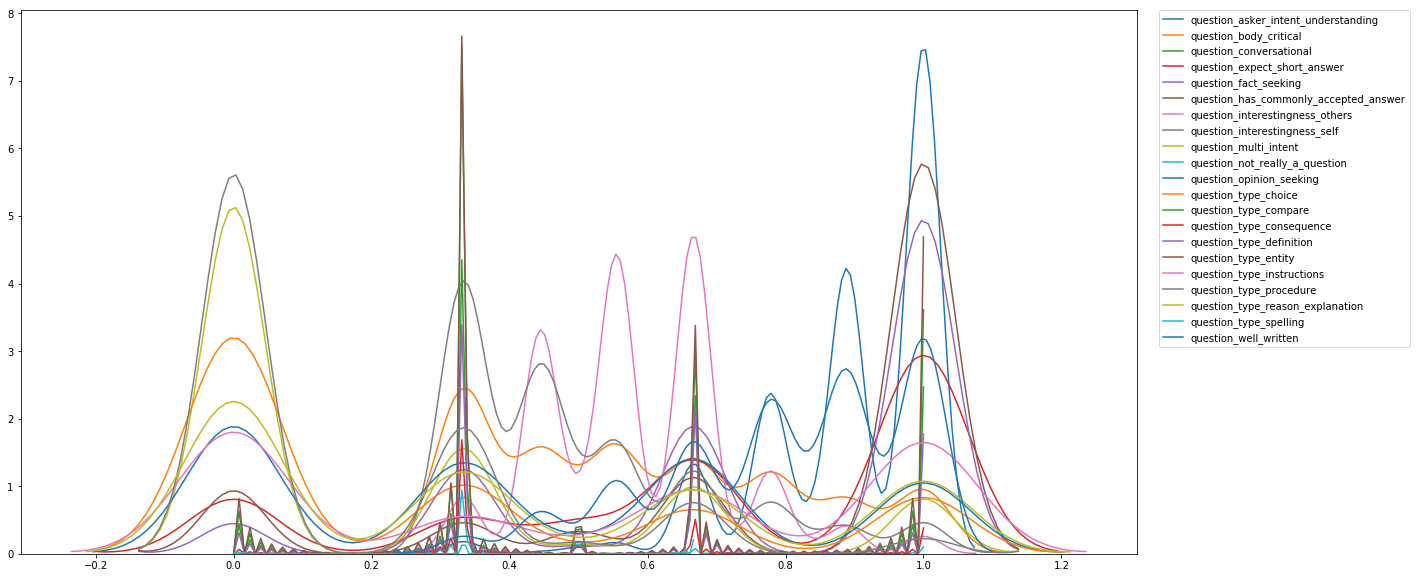

In [44]:
plt.figure(figsize=(20, 10))

for i in range(len(que_targets)):
    sns.distplot(train[que_targets[i]], hist= False , rug= False ,kde=True, label =que_targets[i],axlabel =False )


plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

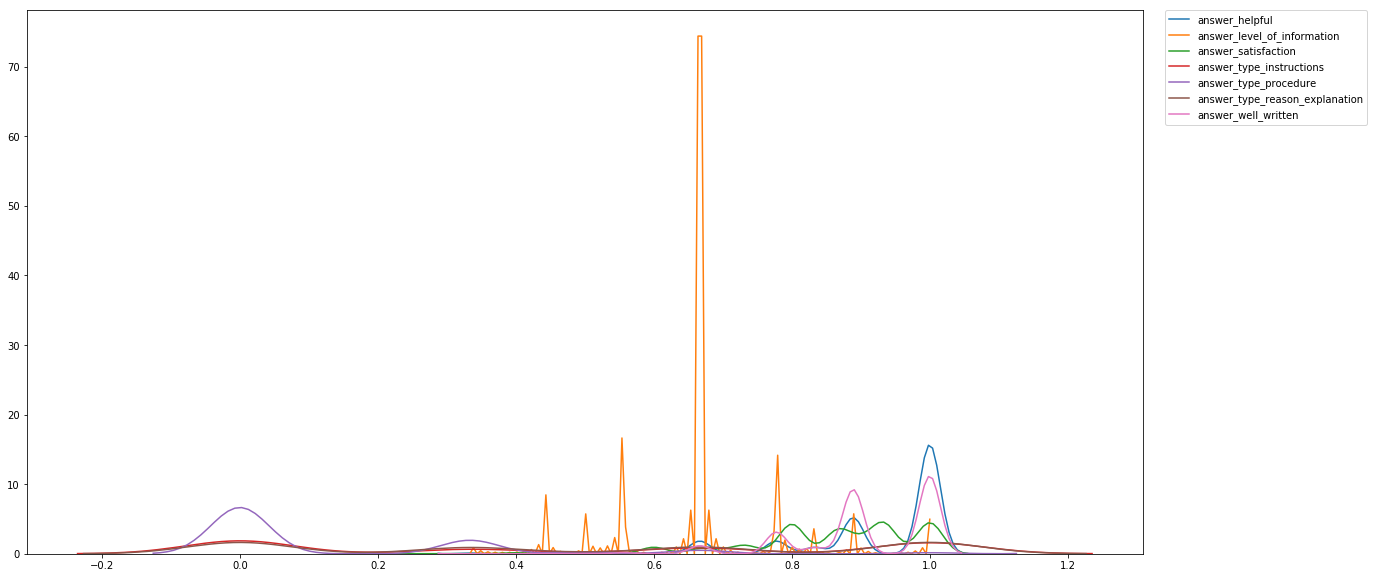

In [47]:
plt.figure(figsize=(20, 10))

for i in range(len(ans_targets)):
    if i not in [2,3]:
        sns.distplot(train[ans_targets[i]], hist= False , rug= False ,kde=True, label =ans_targets[i],axlabel =False )


plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

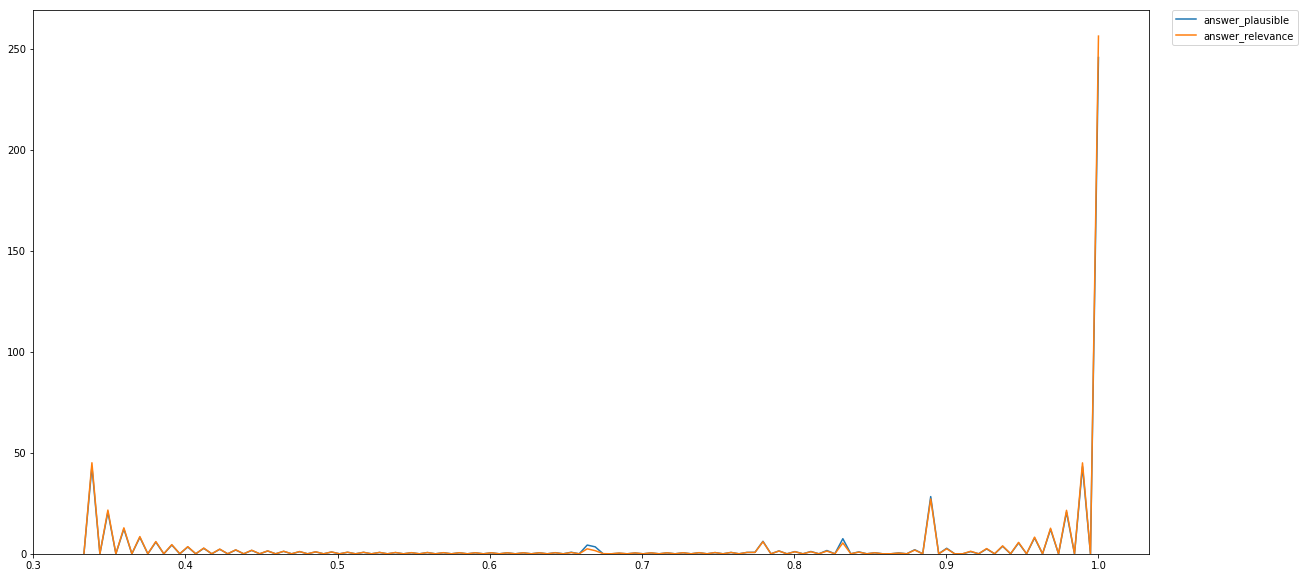

In [48]:
# High frequency
plt.figure(figsize=(20, 10))
sns.distplot(train[ans_targets[2]], hist= False , rug= False ,kde=True, label =ans_targets[2],axlabel =False )
sns.distplot(train[ans_targets[3]], hist= False , rug= False ,kde=True, label =ans_targets[3],axlabel =False )
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

In [51]:
train.groupby('category')[que_targets].mean()

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
category,,,,,,,,,,,,,,,,,,,,,
CULTURE,0.932676,0.668340,0.122880,0.737279,0.758048,0.699204,0.637533,0.623918,0.271893,0.003634,...,0.362063,0.064728,0.015922,0.122880,0.102285,0.171859,0.106784,0.453617,0.005192,0.857390
LIFE_ARTS,0.950400,0.698323,0.131641,0.661730,0.679596,0.646921,0.665491,0.625842,0.310061,0.002351,...,0.346732,0.062529,0.023037,0.018336,0.111189,0.283733,0.125294,0.459567,0.000000,0.883325
SCIENCE,0.874240,0.570672,0.043011,0.636045,0.847359,0.838008,0.586567,0.491897,0.269285,0.003506,...,0.287284,0.050958,0.013558,0.044881,0.090930,0.305984,0.147499,0.557270,0.000000,0.791258
STACKOVERFLOW,0.855192,0.524918,0.009444,0.714552,0.786911,0.882283,0.537288,0.433316,0.155760,0.004655,...,0.180101,0.011838,0.003857,0.004123,0.019420,0.751264,0.202447,0.301676,0.000000,0.733573
TECHNOLOGY,0.884724,0.579885,0.038577,0.703946,0.776253,0.815171,0.571100,0.469275,0.238632,0.005599,...,0.289635,0.030315,0.006077,0.007579,0.053257,0.613956,0.188038,0.332173,0.000000,0.789635


In [63]:
# target_arr=np.array(targets)

## Modeling

In [9]:
def get_score(base_prediction):
    overall_score = 0
    for col in targets:
        overall_score += spearmanr(base_prediction[col], train[col]).correlation/len(targets)
#         print(col, spearmanr(base_prediction[col], train[col]).correlation)
    return overall_score

In [10]:
category_mean_map = train.groupby("category")[targets].mean().T.to_dict()
base_prediction = train["category"].map(category_mean_map).apply(pd.Series)
get_score(base_prediction)

0.1778908169176626

In [11]:
#Interaction term for Category and Host
train["category_host"]=train["category"]+train["host"]
category_mean_map = train.groupby(["category_host"])[targets].mean().T.to_dict()
categorical_prediction = train["category_host"].map(category_mean_map).apply(pd.Series)
get_score(categorical_prediction)

0.26741183151253567

In [12]:
categ={'LIFE_ARTS':1, 'CULTURE':2, 'SCIENCE':3, 'STACKOVERFLOW':4, 'TECHNOLOGY':5}

train["category_num"]=train["category"].map(categ)

In [13]:
train["ans_length"]=train["answer"].apply(len)
# train["ans_length"]=train["ans_length"]/train["ans_length"].mean()
train["ans_length"]

0        833
1        451
2       1048
3       1337
4        225
        ... 
6074    1309
6075    1122
6076     134
6077    1429
6078    1129
Name: ans_length, Length: 6079, dtype: int64

In [14]:
train["length_user_name"]=train["question_user_name"].apply(len)

### Sentiment Analysis

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_score(answer):
    score=[]
    for sentence in answer:
        score.append(analyser.polarity_scores(sentence)['compound'])
    return np.array(score).mean()

In [16]:
train["clean_answer"]=train["answer"].apply(lambda x: [x for x in x.split("\n") if x!=''])

train["ans_sentiment"]=train["clean_answer"].apply(sentiment_analyzer_score)

In [17]:
train["ans_sentiment"]

0      -0.173071
1      -0.363800
2       0.260740
3      -0.000423
4       0.060200
          ...   
6074    0.370033
6075   -0.153300
6076   -0.109100
6077    0.072471
6078    0.241175
Name: ans_sentiment, Length: 6079, dtype: float64

In [18]:
train.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [19]:
tfidf = TfidfVectorizer(ngram_range=(1, 3))
tsvd = TruncatedSVD(n_components = 50)

In [20]:
question_title = tfidf.fit_transform(train["question_title"].values)
question_title_test = tfidf.transform(test["question_title"].values)
question_title = tsvd.fit_transform(question_title)
question_title_test = tsvd.transform(question_title_test)

question_body = tfidf.fit_transform(train["question_body"].values)
question_body_test = tfidf.transform(test["question_body"].values)
question_body = tsvd.fit_transform(question_body)
question_body_test = tsvd.transform(question_body_test)

answer = tfidf.fit_transform(train["answer"].values)
answer_test = tfidf.transform(test["answer"].values)
answer = tsvd.fit_transform(answer)
answer_test = tsvd.transform(answer_test)

question_user_name = train["length_user_name"].values
category = train["category_num"].values
ans_length = train["ans_length"].values
ans_sentiment = train["ans_sentiment"].values

category_mean_map = train.groupby(["category_host"])[targets].mean().T.to_dict()
categorical_prediction = train["category_host"].map(category_mean_map).apply(pd.Series)


test["ans_length"]=test["answer"].apply(len)
test["ans_length"]
test["category_num"]=test["category"].map(categ)
test["clean_answer"]=test["answer"].apply(lambda x: [x for x in x.split("\n") if x!=''])
test["ans_sentiment"]=test["clean_answer"].apply(sentiment_analyzer_score)
test["length_user_name"]=test["question_user_name"].apply(len)



question_user_name_test = test["length_user_name"].values
category_test = test["category_num"].values
ans_length_test = test["ans_length"].values
ans_sentiment_test = test["ans_sentiment"].values



In [21]:
train_features = np.concatenate([question_title, question_body, answer,
                                 category[:, np.newaxis],ans_sentiment[:, np.newaxis],
                                 question_user_name[:, np.newaxis] #, category_te.values
                                ], axis = 1)


test_features = np.concatenate([question_title_test, question_body_test, answer_test,
                                category_test[:, np.newaxis],ans_sentiment_test[:, np.newaxis],
                                question_user_name_test[:, np.newaxis] #, category_te_test.values
                               ], axis = 1)

In [22]:
train_qfeatures = np.concatenate([question_title, question_body, 
                                 category[:, np.newaxis],
                                 question_user_name[:, np.newaxis]
                                ], axis = 1)

train_afeatures = np.concatenate([answer,
                                 category[:, np.newaxis],ans_sentiment[:, np.newaxis]], axis = 1)


test_qfeatures = np.concatenate([question_title_test, question_body_test,
                                category_test[:, np.newaxis],
                                question_user_name_test[:, np.newaxis]
                               ], axis = 1)

test_afeatures = np.concatenate([answer_test,
                                category_test[:, np.newaxis],ans_sentiment_test[:, np.newaxis]], axis = 1)

# NN

In [23]:
def create_model(train_features,train_y):
    inps = Input(shape=(train_features.shape[1],))
    x = Dense(256, activation='elu')(inps)
    x = Dropout(0.2)(x)
#     x = Dense(64)(x)
    x = Dense(train_y.shape[1], activation='sigmoid')(x)
    model = Model(inputs=inps, outputs=x)
    model.compile(
        optimizer=Adam(lr=1e-4),
        loss=['binary_crossentropy']
    )
    model.summary()
    return model

In [24]:
num_folds = 5
fold_scores = []
kf = KFold(n_splits = num_folds, shuffle = True, random_state = 42)
test_preds = np.zeros((len(test_features), len(targets)))

for ind, (train_index, val_index) in enumerate(kf.split(train_features)):
    train_X = train_features[train_index, :]
    train_y = train[targets].iloc[train_index]
    
    val_X = train_features[val_index, :]
    val_y = train[targets].iloc[val_index]
    
    model=create_model(train_features,train_y)

    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    model.fit(train_X, train_y, epochs = 50, validation_data=(val_X, val_y), callbacks = [es])
    preds = model.predict(val_X)
    overall_score = 0
    for col_index, col in enumerate(targets):
        overall_score += spearmanr(preds[:, col_index], val_y[col].values).correlation/len(targets)
        print(col, spearmanr(preds[:, col_index], val_y[col].values).correlation)
    fold_scores.append(overall_score)

test_preds += model.predict(test_features)/num_folds
    
print(np.mean(fold_scores))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 153)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               39424     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                7710      
Total params: 47,134
Trainable params: 47,134
Non-trainable params: 0
_________________________________________________________________
Train on 4863 samples, validate on 1216 samples
Epoch 1/50
4863/4863 [==============================] - 1s 178us/step - loss: 0.4498 - val_loss: 0.4217
Epoch 2/50
4863/4863 [==============================] - 0s 61us/step - loss: 0.4217 - val_loss: 0.411

4863/4863 [==============================] - 0s 51us/step - loss: 0.3818 - val_loss: 0.3878
Epoch 25/50
4863/4863 [==============================] - 0s 51us/step - loss: 0.3818 - val_loss: 0.3878
Epoch 26/50
4863/4863 [==============================] - 0s 51us/step - loss: 0.3816 - val_loss: 0.3875
Epoch 27/50
4863/4863 [==============================] - 0s 52us/step - loss: 0.3812 - val_loss: 0.3876
Epoch 28/50
4863/4863 [==============================] - 0s 50us/step - loss: 0.3814 - val_loss: 0.3881
Epoch 29/50
4863/4863 [==============================] - 0s 51us/step - loss: 0.3813 - val_loss: 0.3873
Epoch 30/50
4863/4863 [==============================] - 0s 52us/step - loss: 0.3814 - val_loss: 0.3881
Epoch 31/50
4863/4863 [==============================] - 0s 51us/step - loss: 0.3809 - val_loss: 0.3876
Epoch 32/50
4863/4863 [==============================] - 0s 50us/step - loss: 0.3808 - val_loss: 0.3891
Epoch 33/50
4863/4863 [==============================] - 0s 51us/step - loss

question_type_procedure 0.2700767541551474
question_type_reason_explanation 0.5102254903969374
question_type_spelling 0.07058754855489156
question_well_written 0.4451909249004981
0.32731701887117526


In [117]:
print(np.mean([0.3195548000990476, 0.3262502129023895, 0.3223079742789521, 0.32946711725179056, 0.3161551600057016]))
print(np.mean([0.32479519515893235, 0.3239592931685162, 0.32134253797573153, 0.328557157181304, 0.31646135779054296]))
print(np.mean([0.3245549329463598, 0.32751179135116537, 0.32642514407411216, 0.32738338815754314, 0.32139129196247973]))

print(0.3255922799258237)

0.32274705290757627
0.32302310825500535
0.325453309698332
0.3255922799258237


In [87]:
targets[29]

'question_well_written'

## Analysis

In [49]:
round(train_features.shape[0]*0.7)

4255

In [134]:
targets

Index(['answer_helpful', 'answer_level_of_information', 'answer_plausible',
       'answer_relevance', 'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written'],
      dtype='object')

In [23]:
pred=[None]*30
test_pred=[None]*30
for i in range(len(targets)):
    
    one_target=train[targets[i]]
    
#     train_X, val_X, train_y, val_y = train_test_split(train_features,one_target, test_size=0.2, random_state=777)
    if i < 9 :
        train_X=train_afeatures
        test_X=test_afeatures
    else:
        train_X=train_qfeatures
        test_X=test_qfeatures

    mod1=LinearRegression()
    mod2=AdaBoostRegressor()
    mod3=XGBRegressor(objective='reg:squarederror')

#     mod3.fit(train_X,train_y)
    mod3.fit(train_X,one_target)

#     pred[i]=mod3.predict(val_X)
    test_pred[i]=mod3.predict(test_X)
    
    
#     overall_score += spearmanr(pred[i], val_y.values).correlation
#     print(i, spearmanr(pred[i], val_y.values).correlation) 



# print("\n\n\nOverall: ")
# print(overall_score/len(targets))

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [55]:
# VALIDATION

overall_score = 0
spearman=[]
pred=[None]*30
test_pred=[None]*30

train_X, val_X, train_y, val_y = train_test_split(train_features,train[targets], test_size=0.2, random_state=777)

for i in range(len(targets)):
    
    train_one_y=train_y.iloc[:,i]

    mod1=LinearRegression()
    mod2=AdaBoostRegressor()
    mod3=XGBRegressor(objective='reg:squarederror')

    mod3.fit(train_X,train_one_y)
    pred[i]=mod3.predict(val_X)
    print("Predicted: "+str(i))

p=np.array(pred)
p=p.T
overall_score = 0
for col_index, col in enumerate(targets):
    overall_score += spearmanr(p[:, col_index], val_y[col].values).correlation/len(targets)
    print(col, spearmanr(p[:, col_index], val_y[col].values).correlation)

print("\n\n\nOverall: "+str(overall_score))


/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Predicted: 0
Predicted: 1
Predicted: 2
Predicted: 3
Predicted: 4
Predicted: 5
Predicted: 6
Predicted: 7
Predicted: 8
Predicted: 9
Predicted: 10
Predicted: 11
Predicted: 12
Predicted: 13
Predicted: 14
Predicted: 15
Predicted: 16
Predicted: 17
Predicted: 18
Predicted: 19
Predicted: 20
Predicted: 21
Predicted: 22
Predicted: 23
Predicted: 24
Predicted: 25
Predicted: 26
Predicted: 27
Predicted: 28
Predicted: 29
answer_helpful 0.19987282323094183
answer_level_of_information 0.38250162301975105
answer_plausible 0.12435106895643877
answer_relevance 0.09909243524505924
answer_satisfaction 0.24904307862627956
answer_type_instructions 0.7269174453827595
answer_type_procedure 0.2602891204325799
answer_type_reason_explanation 0.5459137910283691
answer_well_written 0.1280937093839501
question_asker_intent_understanding 0.33484471013877465
question_body_critical 0.6046669784792577
question_conversational 0.34580817163475625
question_expect_short_answer 0.23866417094461503
question_fact_seeking 0.2920

In [36]:
# VALIDATION - Q,A separate

pred=[None]*30
overall_score = 0
for i in range(len(targets)):
    
    one_target=train[targets[i]]
    
    
    if i < 9 :
        train_X, val_X, train_y, val_y = train_test_split(train_afeatures,one_target, test_size=0.2, random_state=7)

    else:
        train_X, val_X, train_y, val_y = train_test_split(train_qfeatures,one_target, test_size=0.2, random_state=7)

    mod1=LinearRegression()
    mod2=AdaBoostRegressor()
    mod3=XGBRegressor(objective='reg:squarederror')

    mod3.fit(train_X,train_y)
    pred[i]=mod3.predict(val_X)

    
    
    overall_score += spearmanr(pred[i], val_y.values).correlation
    print(i, spearmanr(pred[i], val_y.values).correlation) 



print("\n\n\nOverall: ")
print(overall_score/len(targets))

0 0.1561521111167548
1 0.3341777541328594
2 0.07233419163317333
3 0.051695491321165576
4 0.2074495761503917
5 0.6651229711310459
6 0.14441001358422148
7 0.49470492585924514
8 0.1583237939767057
9 0.3654409107137195
10 0.623696766104946
11 0.33463955127607786
12 0.2110026766999851
13 0.30546863476661523
14 0.3833162074331399
15 0.36795743365974914
16 0.47555064630080035
17 0.34838958535576253
18 0.07166879952809352
19 0.3621741946809549
20 0.5156170625294693
21 0.3220150278457807
22 0.10638302831361096
23 0.33277286962949226
24 0.3819310187285612
25 0.725764940419561
26 0.29109897485285835
27 0.5428693298571567
28 0.052552924697908225
29 0.50474162309165



Overall: 
0.33031410117971516


In [97]:
pred[0]

array([0.91753891, 0.95790617, 0.90934025, ..., 0.95223587, 0.92944667,
       0.94502673])

In [132]:
question_title.shape

(6079, 50)

In [38]:
train[targets[0]]

0       1.000000
1       0.888889
2       0.777778
3       0.833333
4       1.000000
          ...   
6074    1.000000
6075    0.888889
6076    0.888889
6077    0.888889
6078    0.888889
Name: answer_helpful, Length: 6079, dtype: float64

In [145]:
test

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,ans_length,category_num,clean_answer,ans_sentiment,length_user_name
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com,143,2,[There is no consequence for leaving corpses a...,-0.851100,5
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com,317,5,"[I think it is possible with custom fields., A...",0.217300,3
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com,112,2,[You do not have armour in the screenshots. Th...,-0.153100,6
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com,1514,5,[Your Western Digital hard drive is disappeari...,-0.083443,8
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com,480,2,[I called two persons who work for Saudia (tic...,-0.161050,4
5,245,Exactly how are Avenger elites buffed when one...,I understand that elites with the Avenger prop...,Sterno,https://gaming.stackexchange.com/users/3062,\n Only Champion monster types will spawn wit...,ayckoster,https://gaming.stackexchange.com/users/10933,http://gaming.stackexchange.com/questions/7041...,CULTURE,gaming.stackexchange.com,382,2,[ Only Champion monster types will spawn with...,0.116500,6
6,257,Configure which plugin custom post types get r...,I am writing a plugin that creates custom post...,Rabbott,https://wordpress.stackexchange.com/users/35459,\n The issue i'm having is that custom post t...,RRikesh,https://wordpress.stackexchange.com/users/17305,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com,1507,5,[ The issue i'm having is that custom post ty...,0.023885,7
7,267,"Why say ""it rhymes with Grape""?",There is a scene in 21 Jumpstreet where Dave F...,Kevin Howell,https://movies.stackexchange.com/users/645,Opinion: It was a funny(?) joke.\n\nAlthough a...,Andrew Martin,https://movies.stackexchange.com/users/8219,http://movies.stackexchange.com/questions/2109...,LIFE_ARTS,movies.stackexchange.com,981,1,"[Opinion: It was a funny(?) joke., Although a ...",-0.229200,12
8,284,c++ getline and stringstream,"I'm trying to read in a file, which has 5 line...",wfmn17,https://stackoverflow.com/users/1430743,If &gt;&gt; sees that there is nothing left in...,Aasmund Eldhuset,https://stackoverflow.com/users/626853,http://stackoverflow.com/questions/16374187/c-...,STACKOVERFLOW,stackoverflow.com,444,4,[If &gt;&gt; sees that there is nothing left i...,-0.042920,6
9,292,"Outlook doesn't download all emails, whereas i...","When I che

In [87]:
import bert

In [80]:
import gc
gc.collect()

23753

In [24]:
t=np.array(test_pred)
t2=t.T
t2.shape

(476, 30)

In [32]:
submission = pd.DataFrame()
submission["qa_id"]=test["qa_id"]
for col_index, col in enumerate(targets):
    submission[col]=t2[:,col_index]


In [108]:
submission.to_csv("submission.csv", index = False)

In [27]:
submission.head()

,qa_id,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
0,39,0.175706,0.119767,0.189379,0.191362,0.155808,0.039329,0.013202,0.158061,0.179542,...,0.090233,0.007123,0.010739,0.002000,0.013642,0.035061,0.026044,0.149550,0.000356,0.171178
1,46,0.192659,0.130590,0.195794,0.197853,0.176641,0.190104,0.025278,0.046228,0.179280,...,0.040379,0.000201,0.000126,0.000057,0.002122,0.190575,0.038640,0.050171,0.000003,0.156384
2,70,0.186076,0.126293,0.194203,0.194682,0.166624,0.027667,0.021559,0.146229,0.184762,...,0.113556,0.007974,0.009348,0.005527,0.005449,0.027837,0.016854,0.115770,0.000321,0.177922
3,132,0.193241,0.135362,0.197398,0.197716,0.178573,0.132498,0.033065,0.153932,0.184942,...,0.050236,0.003918,0.002190,0.000047,0.001597,0.127137,0.029998,0.135465,0.000010,0.167081
4,200,0.190922,0.142368,0.195803,0.197134,0.179300,0.041263,0.018178,0.162315,0.184523,...,0.067495,0.007330,0.002994,0.001523,0.006304,0.031204,0.021185,0.135805,0.000151,0.169942


In [112]:
submission.head()

,qa_id,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
0,39,0.893574,0.647638,0.938963,0.949405,0.841590,0.020867,0.077992,0.656593,0.918596,...,0.560883,0.206260,0.007055,0.066064,0.101515,0.067022,0.107158,0.627412,0.001137,0.891387
1,46,0.974232,0.645259,0.986066,0.977809,0.874709,0.836266,0.123572,0.370142,0.903319,...,0.290577,0.002549,0.002014,-0.014330,0.023851,0.749636,0.233961,0.261866,-0.000018,0.808878
2,70,0.903463,0.631591,0.962961,0.964338,0.831370,0.170114,0.085045,0.769013,0.924618,...,0.622739,0.037902,0.016676,0.185005,0.006319,0.233942,0.063845,0.616816,0.002589,0.882085
3,132,0.935730,0.708197,0.973837,0.980762,0.851305,0.666206,0.170964,0.660033,0.897477,...,0.190207,0.038406,0.000202,-0.012174,0.040113,0.589872,0.123979,0.482448,0.000725,0.793409
4,200,0.943380,0.689623,0.976873,0.978851,0.896006,0.021591,0.067137,0.614632,0.924365,...,0.461461,0.013444,0.009511,0.063459,-0.010598,0.033178,0.108666,0.672514,-0.000227,0.825439


In [28]:
submission = pd.DataFrame()
submission["qa_id"]=test["qa_id"]
for col_index, col in enumerate(targets):
    submission[col]=test_pred[col_index]

In [30]:
submission.head()

,qa_id,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
0,39,0.907015,0.667845,0.946907,0.949878,0.879090,0.196009,0.084466,0.732220,0.911234,...,0.411267,0.061102,0.009921,0.060283,0.125330,0.097357,0.168120,0.547579,-0.000435,0.894062
1,46,0.946293,0.660090,0.982847,0.982777,0.865891,0.759453,0.089829,0.415692,0.899201,...,0.393885,0.008511,-0.002437,0.005525,0.001269,0.811663,0.246351,0.202738,0.000357,0.843483
2,70,0.903839,0.629932,0.953621,0.963978,0.815442,0.300312,0.111462,0.755992,0.906627,...,0.575582,0.068988,0.020585,0.154319,0.018099,0.200590,0.058795,0.621828,0.000790,0.893175
3,132,0.968164,0.685778,0.969396,0.979191,0.895952,0.704249,0.191413,0.642183,0.912134,...,0.101201,0.012611,0.012461,-0.008992,0.096137,0.700689,0.121406,0.466026,-0.000319,0.720806
4,200,0.951732,0.715292,0.981925,0.979827,0.895551,0.056511,0.058340,0.689481,0.910306,...,0.476388,0.042478,0.012318,0.041211,0.070355,0.171764,0.140981,0.563250,-0.000315,0.854286


In [33]:
# Correct Transposed
submission.head()

,qa_id,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
0,39,0.907015,0.667845,0.946907,0.949878,0.879090,0.196009,0.084466,0.732220,0.911234,...,0.411267,0.061102,0.009921,0.060283,0.125330,0.097357,0.168120,0.547579,-0.000435,0.894062
1,46,0.946293,0.660090,0.982847,0.982777,0.865891,0.759453,0.089829,0.415692,0.899201,...,0.393885,0.008511,-0.002437,0.005525,0.001269,0.811663,0.246351,0.202738,0.000357,0.843483
2,70,0.903839,0.629932,0.953621,0.963978,0.815442,0.300312,0.111462,0.755992,0.906627,...,0.575582,0.068988,0.020585,0.154319,0.018099,0.200590,0.058795,0.621828,0.000790,0.893175
3,132,0.968164,0.685778,0.969396,0.979191,0.895952,0.704249,0.191413,0.642183,0.912134,...,0.101201,0.012611,0.012461,-0.008992,0.096137,0.700689,0.121406,0.466026,-0.000319,0.720806
4,200,0.951732,0.715292,0.981925,0.979827,0.895551,0.056511,0.058340,0.689481,0.910306,...,0.476388,0.042478,0.012318,0.041211,0.070355,0.171764,0.140981,0.563250,-0.000315,0.854286


In [139]:
submission=submission.apply(lambda x: round(abs(x),5))

In [140]:
submission.min()

qa_id                                    39.00000
answer_helpful                            0.82745
answer_level_of_information               0.59557
answer_plausible                          0.85238
answer_relevance                          0.91885
answer_satisfaction                       0.76846
answer_type_instructions                  0.00590
answer_type_procedure                     0.02850
answer_type_reason_explanation            0.08064
answer_well_written                       0.82341
question_asker_intent_understanding       0.75739
question_body_critical                    0.34934
question_conversational                   0.00001
question_expect_short_answer              0.40398
question_fact_seeking                     0.44813
question_has_commonly_accepted_answer     0.22907
question_interestingness_others           0.48563
question_interestingness_self             0.37807
question_multi_intent                     0.03764
question_not_really_a_question            0.00000


In [129]:
submission.min()

qa_id                                    39.00000
answer_helpful                            0.83730
answer_level_of_information               0.56156
answer_plausible                          0.84660
answer_relevance                          0.91574
answer_satisfaction                       0.74703
answer_type_instructions                  0.00319
answer_type_procedure                     0.00650
answer_type_reason_explanation            0.02822
answer_well_written                       0.82855
question_asker_intent_understanding       0.77930
question_body_critical                    0.35172
question_conversational                   0.00004
question_expect_short_answer              0.34206
question_fact_seeking                     0.45699
question_has_commonly_accepted_answer     0.22513
question_interestingness_others           0.47585
question_interestingness_self             0.37349
question_multi_intent                     0.00997
question_not_really_a_question            0.00001


In [106]:
val_y.values[:,0]

array([0.66666667, 1.        , 1.        , ..., 0.88888889, 1.        ,
       1.        ])

In [93]:
# Compatible with tensorflow backend
class SpearmanRhoCallback(Callback):
    def __init__(self, training_data, validation_data, patience, model_name):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
        self.patience = patience
        self.value = -1
        self.bad_epochs = 0
        self.model_name = model_name

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        rho_val = np.mean([spearmanr(self.y_val[:, ind], y_pred_val[:, ind] + np.random.normal(0, 1e-7, y_pred_val.shape[0])).correlation for ind in range(y_pred_val.shape[1])])
        if rho_val >= self.value:
            self.value = rho_val
        else:
            self.bad_epochs += 1
        if self.bad_epochs >= self.patience:
            print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True
            #self.model.save_weights(self.model_name)
        print('\rval_spearman-rho: %s' % (str(round(rho_val, 4))), end=100*' '+'\n')
        return rho_val

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return